In [4]:
%matplotlib inline

import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
from tqdm.notebook import tqdm
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

In [10]:
IMG_H = 28
IMG_W = 28
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BUFFER_SIZE = 20000
BATCH_SIZE = 200

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW


Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)

IW_LR = 1e-4
IW_EPOCH = 90

## Load Dataset

- 因為dataset太大了，記憶體負荷不了，所以改利用將圖片轉換成tfrecord的方式讀取Datas
- 程式參考自: https://www.tensorflow.org/tutorials/load_data/
- Tfrecord是一種二進制的數據格式，用於有效的儲存和讀取數據

In [18]:
data_root = pathlib.Path('./img_align_celeba_png')
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = [path for path in all_image_paths if path[-3:] in ('png')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)


total img num: 202599


- 每2000筆資料寫到一個tfrecord中

In [5]:
ITEMS_PER_FILE = 2000
if not os.path.exists("input") : os.mkdir("input")
#從文件中讀取原始圖片數據
def load_img(img_name):
    raw_img = tf.io.read_file('./' + img_name)
    return raw_img

# Returns a bytes_list from a string / byte.
def _bytes_feature(value): 
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 將圖片轉換成tfrecord的形式(包括使用_bytes_features將圖片轉換為BytesList)
def to_tfrecord(img):
    feature = {
        'img': _bytes_feature(img)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

#使用tf.py_function將to_record應用到圖片數據，並將結果轉換為tensorflow的字符串格式
def tf_serialize_example(img):
    tf_string = tf.py_function(
        to_tfrecord,
        [img],
        tf.string)
    return tf.reshape(tf_string, ())

# 將所有的圖片分為一個個tfrecord片段
def prepare_tfrecords(all_image_paths):
    num = 0
    for i in range(0, len(all_image_paths), ITEMS_PER_FILE):
        raw_image_data = tf.data.Dataset.from_tensor_slices(all_image_paths[i:i+ITEMS_PER_FILE])
        raw_image_data = raw_image_data.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        serialized_features_dataset = raw_image_data.map( \
            tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        filename = f'./input/tfrecord/train_{num:03d}_.tfrecord'
        writer = tf.data.experimental.TFRecordWriter(filename)
        writer.write(serialized_features_dataset)
        num+=1

#prepare_tfrecords(all_image_paths)  #第一次要跑這個

In [6]:
# 對所有圖片進行預處理，包括解碼、調整大小與歸一化
def processing(raw_img):
    img = tf.image.decode_png(raw_img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img,tf.float32)
    img = img / 255.
    return img

# 描述tfrecord中包含的的特徵
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

# 用於解析tfrecord中的single example
def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

# 遍歷所有tfrecord檔案，並用tf.data.TFRecordDataset讀取所有TFrecord檔案
data_root = pathlib.Path('./data/input/tfrecord')
filename_list = list(data_root.glob('*'))
filename_list = [str(path) for path in filename_list]
filename_list = [path for path in filename_list if path[-8:] in ('tfrecord')]
tfrecord_count = len(filename_list)
print('\ntotal tfrecord num:', tfrecord_count)

raw_dataset_train = tf.data.TFRecordDataset(filename_list)


total tfrecord num: 102


In [7]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)
dsTrain = parsed_dataset_train.map(processing)
dsTrain = dsTrain.shuffle(BUFFER_SIZE)
dsTrain = dsTrain.batch(BATCH_SIZE,drop_remainder=True)
dsTrain = dsTrain.prefetch(300)

## Build Model

使用助教的GAN架構，定義Generator與Discriminator的網路架構

In [8]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4

    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

根據Improved WGAN，使用Adam作為optimizer，$\beta_1$ = 0, $\beta_2$ = 0.9

In [9]:
IWG, IWD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.legacy.Adam(learning_rate = IW_LR, beta_1=0, beta_2=0.9)
optimizer_d = keras.optimizers.legacy.Adam(learning_rate = IW_LR, beta_1=0, beta_2=0.9)

根據Improved WGAN Algorithm，建立model
- 在WGAN的基礎上引入Gradient penalty，以保證discriminator的Lipschitz連續性

In [10]:
# training generator
@tf.function
def IWGTrain(c1):
    z = tf.random.normal(BZ) # sample latent variable z form p(z) 隨機生成潛在變數
    with tf.GradientTape() as tpg:
        with tf.GradientTape() as tp_gradientpenalty:
            x = c1 # sample real data x from Pr 隨機抽樣真實資料
            epsilon = np.random.uniform(0, 1) # sample epsilon from U[0,1] 從均勻分布U[0, 1]中隨機取樣epsilon值
            # x_tilde <- G_theta(z) 透過generator生成樣本x_tlide，generator試著生成逼真的樣本，迷惑discriminator
            x_tilde = IWG(z, training = True) 
            #對真實與假資料進行插值
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)
            #根據algorithm的定義計算出Loss
            Dwx_tilde = IWD(x_tilde, training = True)
            Dwx = IWD(x, training = True)
            grad = IWD(x_hat, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_gradientpenalty.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty


            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)
    #updata generator variables based on gradient penalty
    gradient_g = tpg.gradient(lg, IWG.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, IWG.trainable_variables))
    return lg, ld

#training discriminator，和IWGTrain大致類似
#只是一個update generator variable，一個update discriminator variable
@tf.function
def IWDTrain(c1):
    z = tf.random.normal(BZ) 
    with tf.GradientTape() as tpd:
        with tf.GradientTape() as tp_gradientpenalty:
            x = c1 
            epsilon = np.random.uniform(0, 1)

            x_tilde = IWG(z, training = True) 
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)

            Dwx_tilde = IWD(x_tilde, training = True)
            Dwx = IWD(x, training = True)
            grad = IWD(x_hat, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_gradientpenalty.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty

            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)
    #update discriminator variables based on gradient penalty
    gradient_d = tpd.gradient(ld, IWD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, IWD.trainable_variables))
    return lg, ld

In [11]:
IWTrain = (
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWGTrain
)

IWCritic = len(IWTrain)

## Training Model

用於visualize training結果

In [12]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out

def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

用checkpoints存訓練過程

In [13]:
IW_epoch = 0
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(IWG = IWG,
                           IWD = IWD,
                           optimizer_g = optimizer_g,
                           optimizer_d = optimizer_d)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 10)

  0%|          | 0/90 [00:00<?, ?it/s]

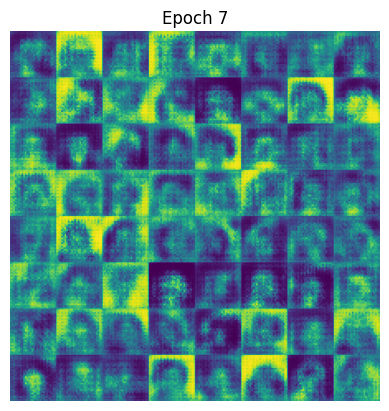

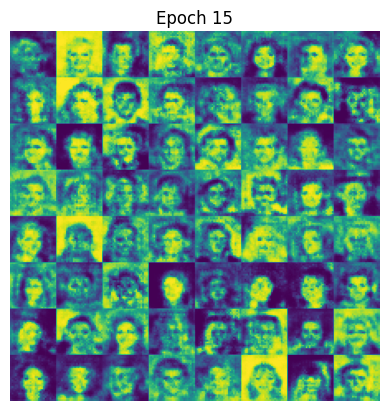

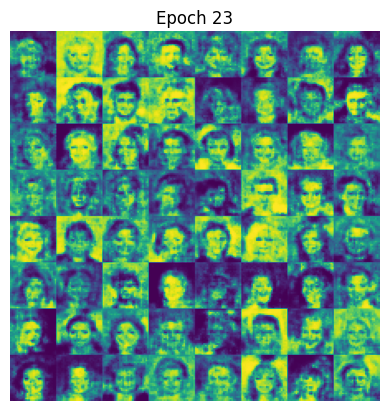

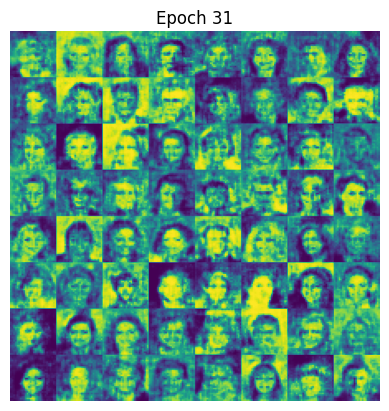

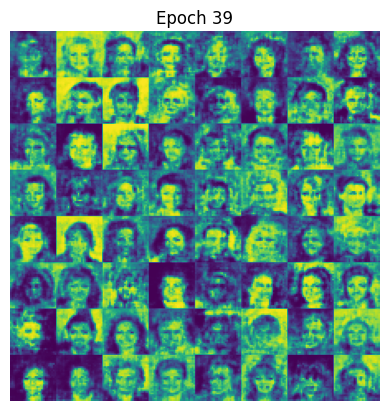

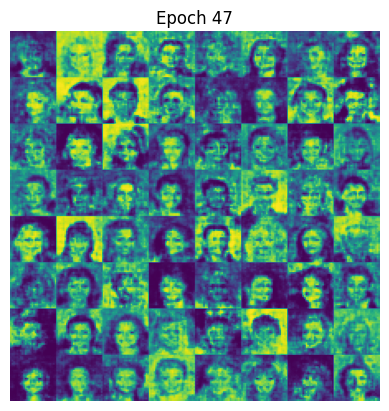

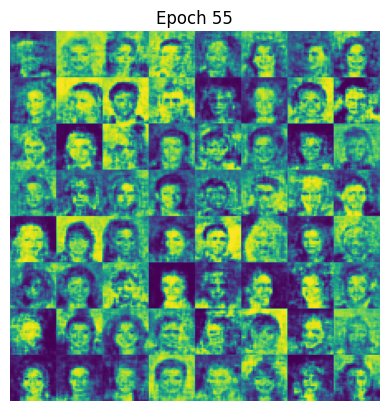

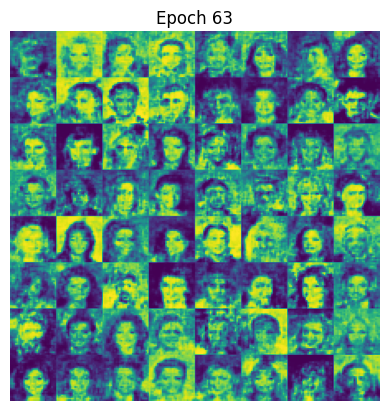

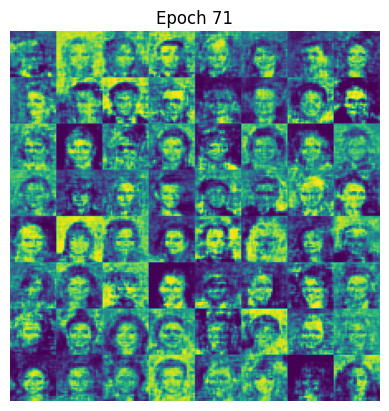

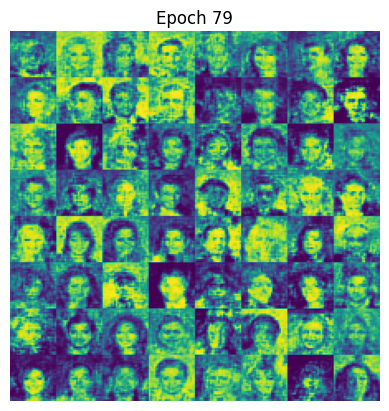

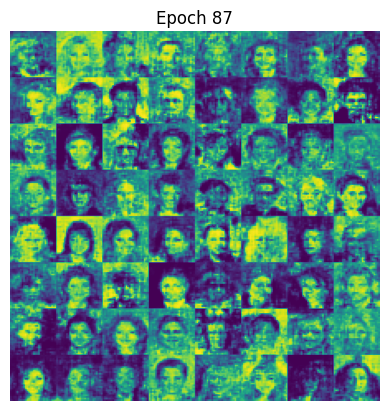

In [14]:
#Initialize record variables
iwlg = [None] * IW_EPOCH #record loss of g for each epoch
iwld = [None] * IW_EPOCH #record loss of d for each epoch
iwsp = [None] * IW_EPOCH #record sample images for each epoch

#計算訓練數據的批次數與總樣本的比例
rsTrain = float(BATCH_SIZE) / float(image_count)
ctr = 0
for ep in tqdm(range(IW_EPOCH)):
    lgt = 0.0
    ldt = 0.0
    #在每個epoch內，iterate dataset中的mini-batch
    for c1 in dsTrain:
        #根據當前的mini-batch計算generator與discriminator的loss
        lg, ld = IWTrain[ctr](c1)
        #用ctr來確保交替更新generator與discriminator
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == IWCritic : ctr = 0
    iwlg[ep] = lgt * rsTrain
    iwld[ep] = ldt * rsTrain

    out = IWG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./imgs_HW/iw_%04d.png" % ep
    )
    iwsp[ep] = img
    if (ep+1) % 8== 0:
        plt.imshow(img[..., 0])
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()
    if (ep+1) % 1 == 0:
        ckpt_manager.save()

檔案雲端連結：https://drive.google.com/drive/folders/1z1O4NoTYdb8kwUSkEZeH_Xmy1-B2eQxk?usp=sharing

In [15]:
utMakeGif(np.array(iwsp), "imgs_HW/iwgan.gif", duration = 2)

MoviePy - Building file imgs_HW/iwgan.gif with imageio.


## Loss curve of generator and discriminator

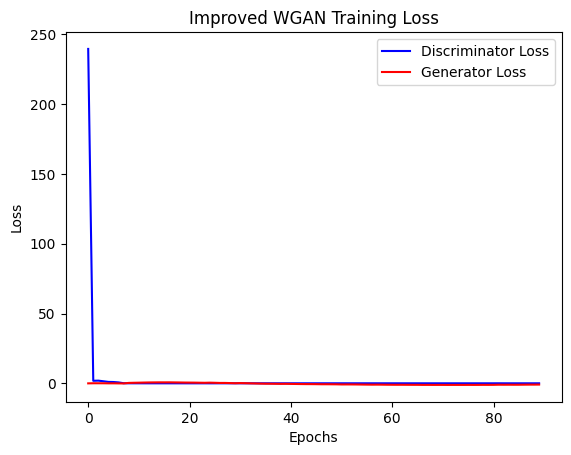

In [16]:
plt.plot(range(IW_EPOCH), iwld, color = "blue", label = "Discriminator Loss")
plt.plot(range(IW_EPOCH), iwlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved WGAN Training Loss")
plt.show()